(lgm-prelims-notebook)=
# Dati longitudinali 

In [38]:
source("_common.R")
suppressPackageStartupMessages({
    library("lavaan")
    library("semPlot")
    library("knitr")
    library("markdown")
    library("patchwork")
    library("psych")
    library("DT")
    library("kableExtra")
    library("lme4")
    library("JWileymisc")
    library("multilevelTools")
    library("data.table")
    library("insight")
})
set.seed(42)

## Considerazioni preliminari

I modelli di crescita sono applicati a dati ottenuti da studi in cui sono state ottenute diverse misure ripetute da più individui. Un problema comune nella ricerca psicologica è lo studio di come le persone differiscono nei loro sentimenti, pensieri e comportamenti nel tempo e nello spazio. L’obiettivo è capire se queste differenze sono sistematiche e come descriverle al meglio. 

Tradizionalmente, gli studi longitudinali erano progettati in modo tale che il numero di valutazioni ripetute fosse relativamente basso (cioè <8) e il numero di individui fosse relativamente elevato (cioè >200). Tuttavia, i progressi sia nelle considerazioni teoriche del cambiamento (ad esempio, la non linearità) sia nella tecnologia per la raccolta dei dati (ad esempio, sondaggi basati sul web, smartphone) hanno notevolmente ampliato le possibilità di raccolta e analisi dei dati longitudinali: {cite:t}`grimm2016growth` discutono applicazioni di modelli di crescita a dati longitudinali ottenuti fino a 50.000 persone e fino a 1.000 valutazioni ripetute.

## Strutture dei dati

I dati longitudinali tipicamente si presentano in due forme: long e wide. Nel formato long, la descrizione del tempo è sulle righe; nel formato wide le variabili relative ad ogni occasione temporale sono organizzate in colonne. È possibile trasformere i dati dal formato long in formato wide e viceversa usando le funzioni R `pivot_wider()` e `pivot_longer()`. La sintassi è spiegata nella pagina web [tidyr](https://tidyr.tidyverse.org/reference/pivot_wider.html).

Per fare un esempio, esaminiamo il cambiamento nel rendimento in matematica dei bambini durante la scuola elementare e media utilizzando il set di dati NLSY-CYA [i dati sono presentati nel capitolo 3 del libro di {cite:t}`grimm2016growth`]. Iniziamo a leggere i dati.

In [10]:
# set filepath for data file
filepath <- "https://raw.githubusercontent.com/LRI-2/Data/main/GrowthModeling/nlsy_math_long_R.dat"
# read in the text data file using the url() function
dat <- read.table(
  file = url(filepath),
  na.strings = "."
) # indicates the missing data designator
# copy data with new name
nlsy_math_long <- dat

# Add names the columns of the data set
names(nlsy_math_long) <- c(
  "id", "female", "lb_wght",
  "anti_k1", "math", "grade",
  "occ", "age", "men",
  "spring", "anti"
)

# view the first few observations in the data set
head(nlsy_math_long)

,id,female,lb_wght,anti_k1,math,grade,occ,age,men,spring,anti
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,201,1,0,0,38,3,2,111,0,1,0
2,201,1,0,0,55,5,3,135,1,1,0
3,303,1,0,1,26,2,2,121,0,1,2
4,303,1,0,1,33,5,3,145,0,1,2
5,2702,0,0,0,56,2,2,100,NA,1,0
6,2702,0,0,0,58,4,3,125,NA,1,2


I dati sono qui forniti nel formato *long*. 

Contiamo il numero di partecipanti.

In [12]:
nlsy_math_long %>% 
  distinct(id) %>% 
  count()

n
<int>
932


Con `pivot_wider` possiamo trasformare i dati in formato *wide*.

In [13]:
nlsy_math_wide <- nlsy_math_long |> 
  pivot_wider(names_from = grade, values_from = math)

nlsy_math_wide |>
  head()

id,female,lb_wght,anti_k1,occ,age,men,spring,anti,3,5,2,4,8,6,7
<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
201,1,0,0,2,111,0,1,0,38,NA,NA,NA,NA,NA,NA
201,1,0,0,3,135,1,1,0,NA,55,NA,NA,NA,NA,NA
303,1,0,1,2,121,0,1,2,NA,NA,26,NA,NA,NA,NA
303,1,0,1,3,145,0,1,2,NA,33,NA,NA,NA,NA,NA
2702,0,0,0,2,100,NA,1,0,NA,NA,56,NA,NA,NA,NA
2702,0,0,0,3,125,NA,1,2,NA,NA,NA,58,NA,NA,NA


## Visualizzazione dei dati longitudinali

Come in qualsiasi analisi statistica, è importante esaminare attentamente i dati. Ciò include la produzione di sia riepiloghi quantitativi che visualizzazioni. 

Per fare un esempio di visualizzazione di dati longitudinali, esaminiamo il cambiamento nel rendimento in matematica dei bambini durante la scuola elementare e media utilizzando il set di dati NLSY-CYA [i dati sono presentati nel capitolo 3 del libro di {cite:t}`grimm2016growth`]. Selezioniamo solo il grado scolastico, il codice identificativo e il punteggio di matematica.

In [ ]:
nlsy_math_only_long <- nlsy_math_long %>%
    dplyr::select(id, grade, math)

Le traiettorie di cambiamento intra-individuale possono essere prodotte nel modo seguente.

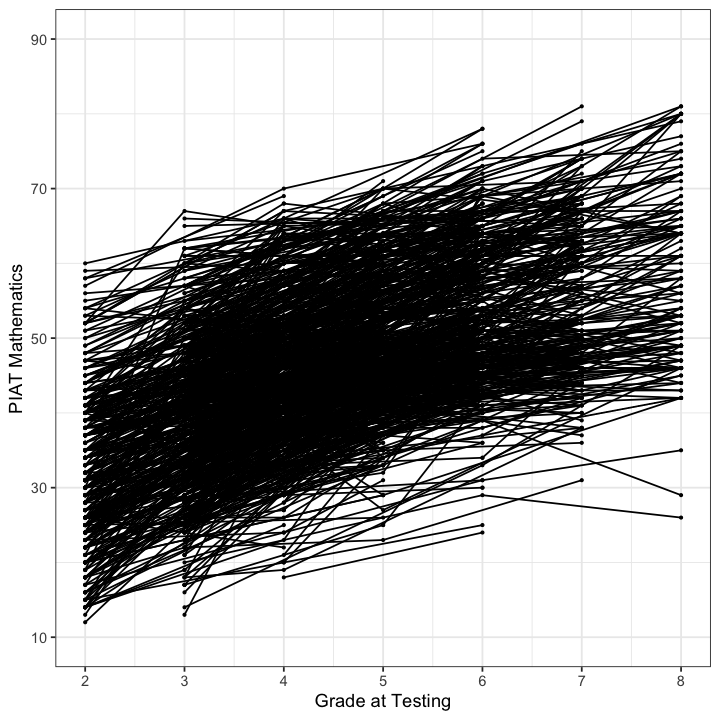

In [3]:
nlsy_math_long |> # data set
  ggplot(aes(x = grade, y = math, group = id)) + # setting variables
  geom_point(size = .5) + # adding points to plot
  geom_line() + # adding lines to plot
  theme_bw() + # changing style/background
  # setting the x-axis with breaks and labels
  scale_x_continuous(
    limits = c(2, 8),
    breaks = c(2, 3, 4, 5, 6, 7, 8),
    name = "Grade at Testing"
  ) +
  # setting the y-axis with limits breaks and labels
  scale_y_continuous(
    limits = c(10, 90),
    breaks = c(10, 30, 50, 70, 90),
    name = "PIAT Mathematics"
  )

Esaminiamo le traiettorie di sviluppo dei primi 9 partecipanti.

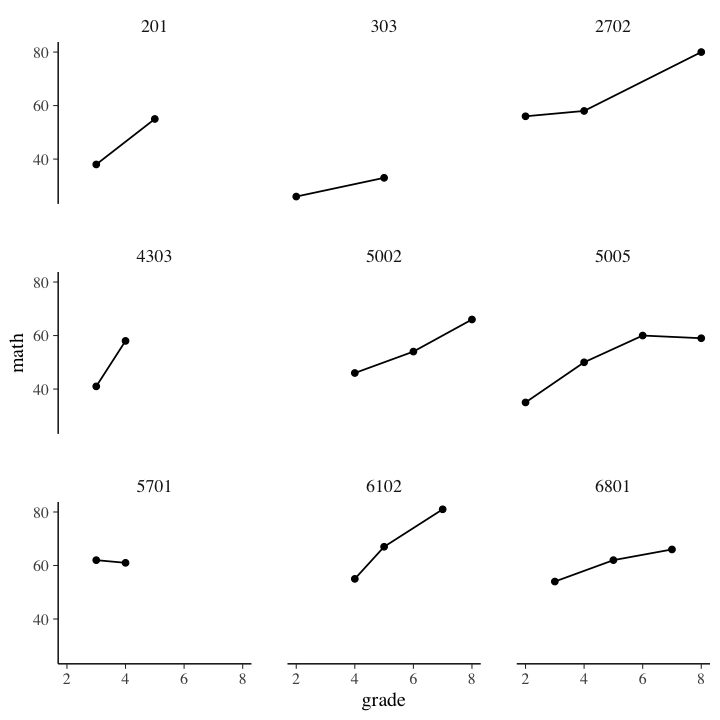

In [20]:
subset_it <- c(201, 303, 2702, 4303, 5002, 5005, 5701, 6102, 6801)
temp <- nlsy_math_long[nlsy_math_long$id %in% subset_it, ]

temp %>%
  ggplot(aes(x = grade, y = math)) +
  geom_point() +
  geom_line() +
  # coord_cartesian(ylim = c(1, 4)) +
  theme(panel.grid = element_blank()) +
  facet_wrap(~id)

## Data screening

Prima di adattare i modelli di crescita, è importante esaminare i dati e ottenere informazioni di base sulle variabili da utilizzare nell’analisi. La selezione preliminare dovrebbe includere l'esame della distribuzione dei punteggi per ogni variabile. Come al solito, le principali statistiche descrittive univariate includono la media, la mediana, la varianza (deviazione standard), l’asimmetria, la curtosi, il minimo, il massimo, l’intervallo e il numero di osservazioni per ogni variabile in base alla metrica del tempo scelta. Le statistiche descrittive bivariate includono correlazioni/covarianze e tabelle di frequenza bivariate per variabili nominali o ordinali. Tutte queste statistiche possono essere esaminate per individuare schemi e relazioni non lineari, così come potenziali valori anomali e codici errati. 

I dati longitudinali sono speciali perché sono ordinati, il che può essere indicizzato lungo una o più metriche del tempo (variabili come occasione di misurazione, età, data, tempo dall’evento, numero di esposizioni, ecc.). Ad esempio, è immediatamente informativo esaminare come la media, la varianza e il numero di casi disponibili cambiano attraverso le misure ripetute (ad esempio wght5, wght6, wght7). Si noti che la selezione della metrica del tempo influenza notevolmente come i risultati di qualsiasi modello di crescita specifico possono essere interpretati. Pertanto, nella fase di selezione dei dati è importante considerare come varie proprietà dei dati longitudinali differiscano quando i dati sono organizzati in relazione a diverse metriche del tempo. 

Per i dati dell'esempio, le statistiche descrittive possono essere ottenute nel modo seguente.

In [4]:
describe(nlsy_math_long) |>
    print()

,vars,n,mean,sd,median,trimmed,mad,min,max,range,skew,kurtosis,se
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
id,1,2221,5.284491e+05,3.273037e+05,497403,5.154669e+05,384144.6252,201,1256601,1256400,0.30258128,-0.8968290,6.945070e+03
female,2,2221,4.934714e-01,5.000700e-01,0,4.918402e-01,0.0000,0,1,1,0.02609895,-2.0002188,1.061100e-02
lb_wght,3,2221,7.969383e-02,2.708796e-01,0,0.000000e+00,0.0000,0,1,1,3.10187193,7.6250432,5.747805e-03
anti_k1,4,2221,1.416929e+00,1.497133e+00,1,1.194147e+00,1.4826,0,8,8,1.14091473,1.1448077,3.176772e-02
math,5,2221,4.611977e+01,1.279992e+01,46,4.621666e+01,11.8608,12,81,69,-0.03406619,-0.1808447,2.716020e-01
grade,6,2221,4.512382e+00,1.769220e+00,4,4.435566e+00,1.4826,2,8,6,0.25689681,-0.9232006,3.754115e-02
occ,7,2221,2.841063e+00,7.886855e-01,3,2.774902e+00,1.4826,2,5,3,0.54731500,-0.4754854,1.673515e-02
age,8,2221,1.269032e+02,2.206059e+01,126,1.262802e+02,25.2042,82,175,93,0.18672163,-0.9115950,4.681044e-01
men,9,1074,1.945996e-01,3.960766e-01,0,1.186047e-01,0.0000,0,1,1,1.54069191,0.3740825,1.208585e-02


Esaminiamo le statistiche descrittive bivariate.

In [5]:
cor(nlsy_math_long, use='pairwise.complete.obs') |> 
  round(2)

,id,female,lb_wght,anti_k1,math,grade,occ,age,men,spring,anti
id,1.00,-0.01,-0.01,-0.02,-0.22,-0.01,0.01,-0.01,-0.02,-0.11,0.01
female,-0.01,1.00,0.06,-0.09,-0.05,0.00,-0.02,-0.04,0.02,0.04,-0.07
lb_wght,-0.01,0.06,1.00,0.03,-0.03,-0.02,-0.03,0.01,0.04,0.03,0.02
anti_k1,-0.02,-0.09,0.03,1.00,-0.08,-0.03,-0.04,-0.01,0.01,-0.01,0.52
math,-0.22,-0.05,-0.03,-0.08,1.00,0.59,0.53,0.58,0.30,0.29,-0.05
grade,-0.01,0.00,-0.02,-0.03,0.59,1.00,0.87,0.95,0.62,0.12,0.04
occ,0.01,-0.02,-0.03,-0.04,0.53,0.87,1.00,0.86,0.57,0.17,0.04
age,-0.01,-0.04,0.01,-0.01,0.58,0.95,0.86,1.00,0.64,0.21,0.06
men,-0.02,0.02,0.04,0.01,0.30,0.62,0.57,0.64,1.00,0.16,0.13
spring,-0.11,0.04,0.03,-0.01,0.29,0.12,0.17,0.21,0.16,1.00,-0.01


Scomponiamo i punteggi nelle componenti tra i soggetti ed entro i soggetti.

Esaminiamo la distribuzione delle medie dei punteggi tra i soggetti.

In [ ]:
tmp <- meanDecompose(math ~ id, data = nlsy_math_long)

In [ ]:
plot(
    testDistribution(
        tmp[["math by id"]]$X,
        extremevalues = "theoretical", ev.perc = .001
    ),
    varlab = "Between Person Math Scores"
)

Esaminiamo la distribuzione dei punteggi entro i soggetti.

In [ ]:
plot(
    testDistribution(
        tmp[["math by residual"]]$X,
        extremevalues = "theoretical", ev.perc = .001
    ),
    varlab = "Within Person Math Scores"
)

Per l'eliminazione degli outlier, si 

## Attendibilità

Come in tutte le analisi, i ricercatori dovrebbero esaminare l’affidabilità dei loro strumenti di misurazione. Un modo semplice per calcolare l'attendibilità dello strumento usato è quello di trovare, ad esempio, $\omega$ di McDonald in ciascuna rilevazione temporale. 

Questo indice però è distinto da quelle che sono le misure di affidabilità degli indici del cambiamento. In generale, la misura dell'affidabilità degli indici di cambiamento risulta particolarmente difficile da affrontare nel caso dei disegni longitudinali intensivi.

L’affidabilità è definita come la proporzione di varianza nei punteggi osservati tra gli individui che può essere attribuita alla varianza nei punteggi veri piuttosto che alla varianza dell’errore.

$$
ICC = \frac{\text{varianza di interesse}}{\text{varianza di interesse} + \text{varianza d'errore}},
$$

Per le misure di differenza individuale derivate dagli ILD, l’affidabilità delle medie intra-individuali $\bar{y}$ può essere facilmente stimata. La proporzione di varianza "vera" nelle medie è catturata dalla correlazione intraclasse (ICC). Anche l'ICC viene calcolato come un rapporto tra varianze:

$$
\rho^2_{\bar{y}} = \frac{\hat{\tau}^2_{\mu}}{\hat{\tau}^2_{\mu} + \hat{\tau}^2_{\varepsilon}}.
$$

Il coefficiente di correlazione intraclasse (ICC) è una misura della somiglianza tra le osservazioni all’interno di un gruppo o cluster. Può essere stimato utilizzando un modello misto lineare con effetto casuale dei soggetti (cluster) ed errore casuale come componenti. L’ICC viene calcolato come il rapporto tra la varianza tra le medie dei cluster di ragruppamento dei dati e la varianza totale (ovvero, la varianza tra i cluster più la varianza all’interno dei cluster). 

Il coefficiente ICC viene calcolato usando i modelli misti. 

Facciamo un esempio con i dati `nlsy_math_long`. 

In [5]:
nlsy_math_only_long <- nlsy_math_long %>%
    dplyr::select(id, grade, math)

nlsy_math_only_long |>
    head()

,id,grade,math
,<int>,<int>,<int>
1,201,3,38
2,201,5,55
3,303,2,26
4,303,5,33
5,2702,2,56
6,2702,4,58


Per trovare il coefficiente ICC possiamo usare, ad esempio, la funzione `iccMixed` specificando un raggruppamento dei dati sia nei termini dei soggetti. In questo modo otteniamo il valore di 0.287.

In [21]:
iccMixed(
  dv = "math",
  id = c("id"),
  data = nlsy_math_long
)

Var,Sigma,ICC
<chr>,<dbl>,<dbl>
id,47.02036,0.2872289
Residual,116.68307,0.7127711


Per capire meglio il significato di questo valore, replichiamo il risultato usando `lmer`, ovvero adattando ai dati un modello misto con un effetto random per i soggetti.

In [35]:
m <- lmer(math ~ 1 + (1 | id), data = nlsy_math_only_long)

Il modello misto decompone la varianza totale in due componenti: la varianza che dipende dalla differenze tra le medie di ciascun soggetto (tra i soggetti, o varianza delle intercette individuali, $\tau_{00}$) e la varianza che dipende dalle variazioni di ciascun soggetto attorno alla sua media.

Calcoliamo la varianza totale dei punteggi di matematica.

In [31]:
var(nlsy_math_only_long$math)

[1] 163.8379

Esaminiamo ora la scomposizione della varianza eseguita dal modello misto. Si noti che la somma delle due componenti è uguale alla varianza totale.

In [32]:
VarCorr(m)

 Groups   Name        Std.Dev.
 id       (Intercept)  6.8571 
 Residual             10.8020 

In [33]:
6.8571^2 + 10.8020^2

[1] 163.703

Il coefficiente ICC è data dal rapporto tra la varianza attribuibile alla variazione tra le medie dei soggetti e la varianza totale.

In [34]:
6.8571^2 / (6.8571^2 + 10.8020^2)

[1] 0.2872263

Questa strategia si applica solo alle medie intra-individuali e non ad altri indici di differenze intra-individuali (ILD). Altri metodi di stima dell’affidabilità possono essere utilizzati per qualsiasi indice ILD, ma hanno limitazioni pratiche. Ad esempio, il coefficiente di affidabilità test-retest può essere stimato per qualsiasi indice ILD calcolato in due periodi di tempo diversi, ma presuppongono che i punteggi veri non cambino tra i periodi di tempo. L’affidabilità degli indici ILD può anche essere calcolata utilizzando forme parallele del test, ma queste non sono spesso disponibili.

Per esempio, prendiamo in considerazione le variazioni dell’umore di una persona. La varianza affettiva intra-personale può essere indicizzata in due modi: variazione stocastica e sistematica. La varianza stocastica si riferisce alla volatilità nei livelli di affetto e può essere misurata utilizzando un indice come la deviazione standard intra-individuale. La varianza sistematica si riferisce a variazioni ordinate nel tempo e può essere rappresentata da coefficienti di regressione che riflettono costrutti come l’inerzia emotiva o la reattività allo stress. Tuttavia, per quanto sia importante, la misurazione dell’affidabilità della componente sistematica della variazione intra-individuale non trova una semplice soluzione ed è un argomento oggetto di dibattito nella letteratura metodologica corrente.

### Analisi con `lmer`

L’adattamento di modelli lineari misti in R si ottiene mediante la funzione `lmer()` nel pacchetto `lme4`. Questa funzione accetta i seguenti argomenti:

- formula: una formula lineare a due lati che descrive sia gli effetti fissi che gli effetti casuali del modello, con la risposta a sinistra dell’operatore `~` e i predittori e gli effetti casuali sulla destra dell’operatore `~`. 
- data: Un data.frame, che deve essere nel cosiddetto formato “lungo”, con una singola riga per osservazione. 

Iniziamo a descrivere la sintassi che consente la specificazione di un modello misto. Gli effetti fissi sono specificati come segue.

| Formula	| Description |
| --------- | ----------- |
| `a + b`	| main effects of a and b (and no interaction) |
| `a:b`	| only interaction of a and b (and no main effects) |
| `a * b` |	main effects and interaction of a and b (expands to: a + b + a:b) |
| `(a+b+c)^2`	| main effects and two-way interactions, but no three-way interaction (expands to: `a + b + c + a:b + b:c + a:c`) |
| `(a+b)*c`	|all main effects and pairwise interactions between c and a or b (expands to: `a + b + c + a:c + b:c`) |
| `0 + a` | 0 suppresses the intercept resulting in a model that has one parameter per level of a (identical to: `a - 1`) |

Gli effetti random vengono aggiunti alla formula tra parentesi `()`. All’interno di queste parentesi si fornisce sul lato sinistro di un segno condizionale `|` la specifica degli effetti casuali relativi alle pendenze individuali da includere nel modello. Sul lato destro di questo segno condizionale, si specifica il fattore di raggruppamento o i fattori di raggruppamento da cui dipendono questi effetti casuali. I fattori di raggruppamento devono essere di classe `factor` (cioè non possono essere variabili numeriche).

Gli effetti random vengono specificati come segue.

| Formula	| Description |
| --------- | ----------- |
| `(1\|s)`	| random intercepts for unique level of the factor s |
| `(1\|s) + (1\|i)`	| random intercepts for each unique level of s and for each unique level of i |
| `(1\|s/i)`	| random intercepts for factor s and i, where the random effects for i are nested in s. This expands to `(1\|s) + (1\|s:i)` , i.e. a random intercept for each level of s, and each unique combination of the levels of s and i. Nested random effects are used in so-called multilevel models. For example, s might refer to schools, and i to classrooms within those schools. |
| `(a\|s)`	| random intercepts and random slopes for a, for each level of s. Correlations between the intercept and slope effects are also estimated -- identical to `(a*b\|s))` |
| `(a*b\|s)` |	random intercepts and slopes for a, b, and the a:b interaction, for each level of s. Correlations between all the random effects are estimated. |
| `(0+a\|s)`	| random slopes for a for each level of s, but no random intercepts |
| `(a\|\|s)` | random intercepts and random slopes for a, for each level of s, but no correlations between the random effects (i.e. they are set to 0). This expands to: `(0+a\|s) + (1\|s)` |

### Formulazione del modello

In precedenza abbiamo descritto la variazione media tra gli individui mediante un modello misto ad intercetta casuale. È possibile estendere questo modello a casi più complessi, per esempio quello che assume una retta di regressione con pendenza ed intercetta diversa per ciascun soggetto. Per i dati esaminati sopra possiamo specificare un tale modello in `lmer` usando la sintassi seguente.

In [36]:
m <- lmer(math ~ grade + (1 + grade | id), data = nlsy_math_long)

Invece di calcolare separatamente le rette di regressione per ciascun soggetto, i coefficienti individuali dell'intercetta sono considerati come componenti casuali di una distribuzione di coefficienti relativi all'intercetta complessiva del gruppo, che corrisponde all'effetto fisso del modello. Allo stesso modo, i coefficienti individuali della pendenza delle rette di regressione sono considerati come componenti casuali di una distribuzione di coefficienti relativi alla pendenza complessiva della retta che descrive l'andamento complessivo dei dati nel campione.

Nel caso in cui sia specificata una componente casuale `(1 + grado | id)` per intercette e pendenze, il modello misto stima anche una correlazione tra i parametri delle intercette e quelli delle pendenze individuali. Di conseguenza, in un modello misto complesso come questo, le componenti di varianza attribuibili ai vari effetti del modello (fissi e casuali) non sono più indipendenti e la varianza totale non può essere scomposta in componenti indipendenti attribuibili alle varie componenti del modello.

È possibile estrarre le componenti di varianza di un modello misto dall'oggetto creato dalla funzione `lmer` utilizzando le funzioni fornite dal pacchetto `insight`. Nel caso dell'esempio presente, otteniamo i risultati seguenti.

In [40]:
get_variance(m) |>
    print()

$var.fixed
[1] 58.94602

$var.random
[1] 70.66767

$var.residual
[1] 36.23643

$var.distribution
[1] 36.23643

$var.dispersion
[1] 0

$var.intercept
      id 
68.40554 

$var.slope
 id.grade 
0.7391598 

$cor.slope_intercept
        id 
-0.2353174 



Una descrizione visiva della varianza delle varie componenti del modello può essere ottenuta mediante la funzione `modelDiagnostics` del pacchetto `JWileymisc`.

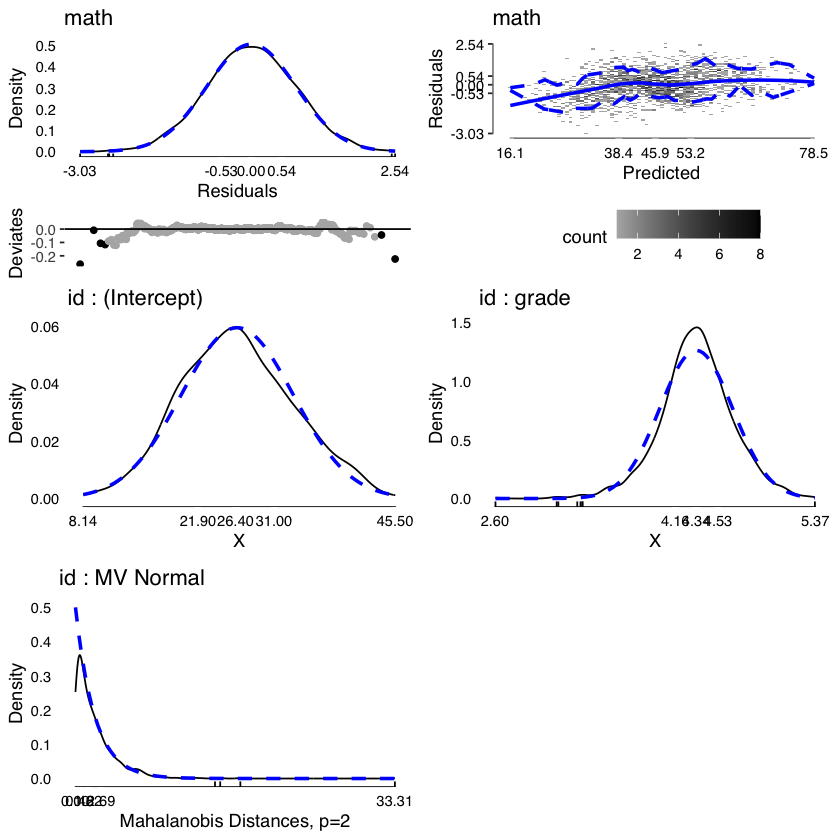

In [21]:
md <- modelDiagnostics(m, ev.perc = .001)
plot(md, ask = FALSE, ncol = 2, nrow = 3)

Una descrizione dei parametri del modello può essere ottenuta nel modo seguente.

In [42]:
mt <- modelTest(m)
names(mt)
APAStyler(mt) |>
    print()

Parameters and CIs are based on REML, 
but modelTests requires ML not REML fit for comparisons, 
and these are used in effect sizes. Refitting.



[1] "FixedEffects"  "RandomEffects" "EffectSizes"   "OverallModel"

                        Term                     Est           Type
 1:              (Intercept) 26.59*** [25.66, 27.51]  Fixed Effects
 2:                    grade  4.34*** [ 4.17,  4.51]  Fixed Effects
 3: cor_grade.(Intercept)|id                   -0.24 Random Effects
 4:        sd_(Intercept)|id                    8.27 Random Effects
 5:              sd_grade|id                    0.86 Random Effects
 6:                    sigma                    6.02 Random Effects
 7:                 Model DF                       6  Overall Model
 8:               N (Groups)                id (932)  Overall Model
 9:         N (Observations)                    2221  Overall Model
10:                   logLik                -7968.69  Overall Model
11:                      AIC                15949.39  Overall Model
12:                      BIC                15983.62  Overall Model
13:              Marginal R2                    0.36  Overall Model
14:              Marginal F2                    

La varianza spiegata dal modello viene ottenuta nel modo seguente.

In [44]:
modelPerformance(m) |>
    print()

$Performance
    Model Estimator N_Obs N_Groups      AIC      BIC        LL LLDF   Sigma
1: merMod      REML  2221 id (932) 15952.99 15987.22 -7970.494    6 6.01967
   MarginalR2 ConditionalR2 MarginalF2 ConditionalF2
1:  0.3553142      0.781476  0.5511433      3.576157

attr(,"class")
[1] "modelPerformance.merMod" "modelPerformance"       


## Invarianza di misurazione

Quando si lavora con dati di misure ripetute, la comparabilità dei punteggi tra le occasioni di misurazione richiede un certo livello di invarianza di misurazione. Lo strumento di misurazione misura lo stesso costrutto nella stessa metrica in ogni occasione? Formalmente, l’invarianza di misurazione garantisce che i punteggi siano confrontabili sia tra le persone che tra le occasioni di misurazione. Ad esempio, l’invarianza di misurazione tra le misure ripetute del peso degli individui è facilitata dall’uso dello stesso dispositivo di misurazione (bilancia) ogni anno, a condizione che la bilancia sia tarata nello stesso modo ogni anno. Se la bilancia è tarata in modo diverso in occasioni diverse o se vengono utilizzate unità di misura diverse, i punteggi risultanti non possono essere confrontati quantitativamente: lo strumento di misurazione è non invariante. Quando si lavora con dispositivi fisici, l’invarianza di misurazione viene testata e garantita attraverso la taratura. Quando si lavora con scale psicologiche, l’invarianza di misurazione viene o assunta (il che non ideale) o testata utilizzando modelli di misurazione formali.



